In [5]:
# %%
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
import pathlib 
import os 
import ot
warnings.filterwarnings("ignore")

from tqdm import tqdm

project = "ecd_wgs_enriched_features"
outputdir = f"/Volumes/HNSD01/outdir/{project}"
mainsrc = "/Users/hieunguyen/src/ecd_wgs_enriched_features"

cancer_type = "Lung"
tss_type = "biomart"
gene_set = "up" 

inputdir = os.path.join("/Volumes/HNSD01/storage/highdepth_WGS_TSS_customGenes", cancer_type, tss_type, f"{gene_set}_genes")
path_to_03_output = os.path.join(outputdir, "03_output", cancer_type, tss_type, f"{gene_set}_genes")
os.system(f"mkdir -p {path_to_03_output}")

all_input_files = [item for item in pathlib.Path(inputdir).glob("*.stat")]

metadata = pd.read_csv(os.path.join(mainsrc, "metadata.csv"))
depthdf = pd.read_csv(os.path.join(mainsrc, "depth.csv"))
selected_features = "MeanDepth"
file = all_input_files[0]

sampleid = file.name.split("_")[0]
tmpdf = pd.read_csv(file, sep = "\t")
tmpdf = tmpdf.head(tmpdf.shape[0] - 1)
tmpdf = tmpdf[["GeneID", "TotalDepth"]]
tmpdf["norm_depth"] = tmpdf["TotalDepth"] / depthdf[depthdf["SampleID"] == sampleid].total_read.unique()[0]
tmpdf = tmpdf[["GeneID", "norm_depth"]]
tmpdf.columns = ["GeneID", sampleid]

for file in all_input_files[1:]:
    sampleid = file.name.split("_")[0]
    tmpdf2 = pd.read_csv(file, sep = "\t")
    tmpdf2 = tmpdf2.head(tmpdf2.shape[0] - 1)
    tmpdf2 = tmpdf2[["GeneID", "TotalDepth"]]
    tmpdf2["norm_depth"] = tmpdf2["TotalDepth"] / depthdf[depthdf["SampleID"] == sampleid].total_read.unique()[0]
    tmpdf2 = tmpdf2[["GeneID", "norm_depth"]]
    tmpdf2.columns = ["GeneID", sampleid]
    tmpdf = tmpdf.merge(tmpdf2, on = "GeneID", how = "outer")
df = tmpdf.copy()
df.columns = [item.split("-")[1] if "-" in item else item for item in df.columns]
df = df.set_index("GeneID")

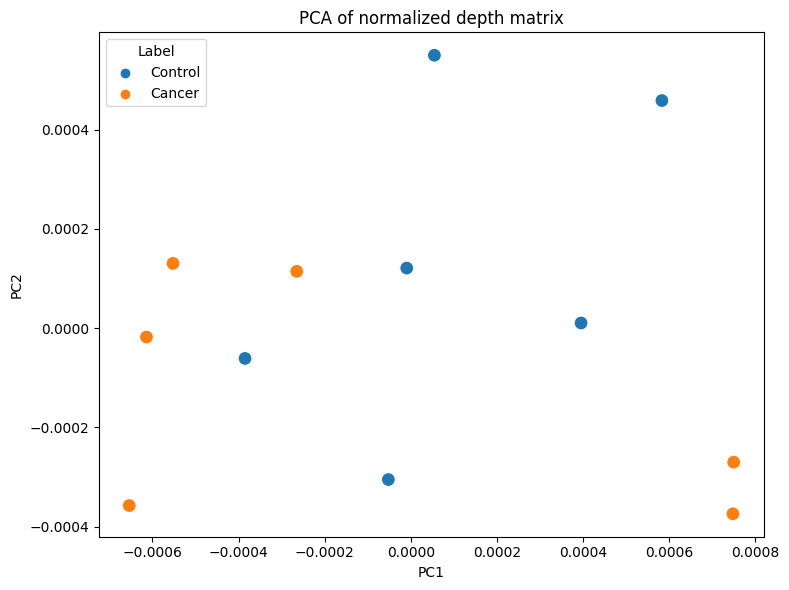

In [6]:
from sklearn.decomposition import PCA

# Prepare data for PCA
X = df.T  # samples as rows, genes as columns

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Add PCA results to metadata
metadata_pca = metadata.copy()
metadata_pca["PC1"] = pca_result[:, 0]
metadata_pca["PC2"] = pca_result[:, 1]

# Plot PCA colored by Label
plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata_pca, x="PC1", y="PC2", hue="Label", s=100)
plt.title("PCA of normalized depth matrix")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

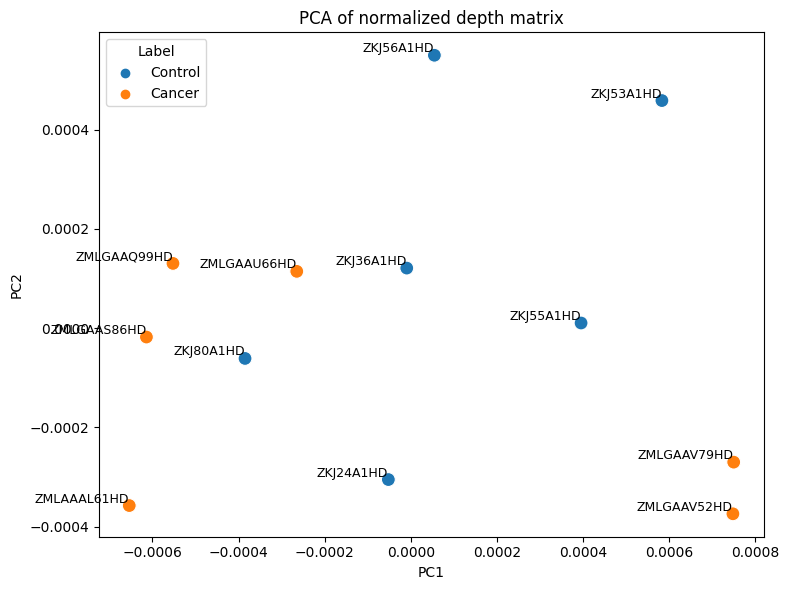

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata_pca, x="PC1", y="PC2", hue="Label", s=100)
for i, row in metadata_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], row["LABCODE"], fontsize=9, ha='right', va='bottom')
plt.title("PCA of normalized depth matrix")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

<Axes: ylabel='GeneID'>

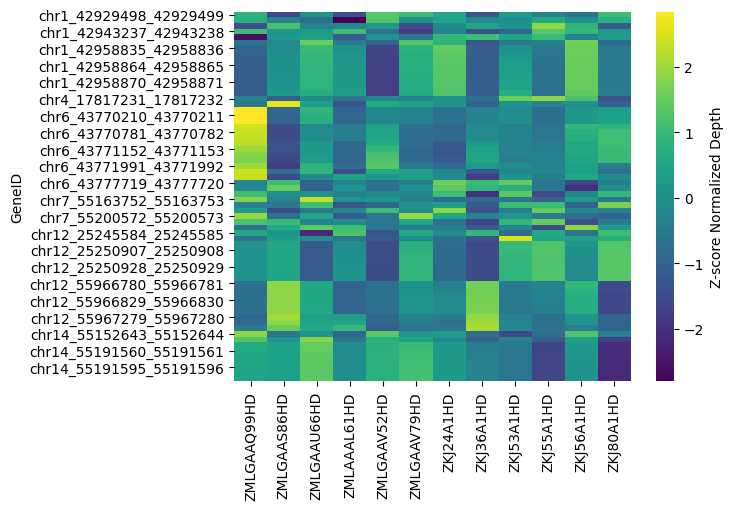

In [8]:
from scipy.stats import zscore

cancer_samples = metadata[metadata["Label"] == "Cancer"]["LABCODE"].tolist()
control_samples = metadata[metadata["Label"] == "Control"]["LABCODE"].tolist()
plotdf = df[cancer_samples + control_samples].copy()
# Z-score scale across samples (columns)
plotdf_z = plotdf.apply(zscore, axis=1)

sns.heatmap(plotdf_z, cmap="viridis", cbar_kws={'label': 'Z-score Normalized Depth'})
